取得 台指期 與小外資 投信連線

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')
one_year_ago_str = '20210601'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])


In [3]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')
one_year_ago_str = '20210101'


# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210601'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])

tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '120MA']= tx_df_raw['最後成交價'].rolling(120).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)

計算均線上的個數

In [4]:
import collections
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

MA_count_list = pd.DataFrame()

for day in data_date_list:

        MA_count_list_oneday = pd.DataFrame()

        day = day.strftime('%Y-%m-%d')
        # 取每日count
        oneday_list = stock_df_raw[stock_df_raw['Date'] == day].copy()  
        MA_count = len(oneday_list)
        MA5_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['5MA']])
        MA20_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['20MA']])
        MA60_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['60MA']])

        MA_count = {
        "date": [day],
        "MA5_count": [round(100*MA5_count/MA_count,2)],
        "MA20_count": [round(100*MA20_count/MA_count,2)],
        "MA60_count": [round(100*MA60_count/MA_count,2)],
        }
        
        MA_count_list_oneday = pd.DataFrame(MA_count)
        MA_count_list = pd.concat([MA_count_list,MA_count_list_oneday])

MA_count_list.head(5)

,date,MA5_count,MA20_count,MA60_count
0,2024-09-18,64.98,38.90,32.33
0,2024-09-16,83.30,41.81,31.90
0,2024-09-13,75.74,32.56,28.41
0,2024-09-12,59.03,26.74,25.93
0,2024-09-11,28.73,19.30,22.80


回測結果
MA60_count < 26 而且放26個交易日(putday =25所以是第26) 賺34381.0 交易39筆

出現的第一天步動作 第二天開始開盤買進

因為 tx_df_raw 資料最早只到 2021-09-06

In [184]:
MA60_count_low60 = MA_count_list[(MA_count_list['MA60_count'] < 29) & (MA_count_list['date'] > '2021-09-06') ]
day_list = MA60_count_low60['date'].unique().tolist()
day_list = pd.to_datetime(day_list)
day_list = day_list.sort_values()

# 假設你的日期列表是 day_list
day_diff = day_list.to_series().diff().dt.days

# 创建DataFrame
day_df = pd.DataFrame({
    'day_list': day_list,
    'day_diff': day_diff
})
newday_list = []
newday_list = day_df[day_df['day_diff'] == 1]['day_list']
# newday_list

# for today_str in newday_list:

#         today_str = today_str.strftime('%Y-%m-%d')
#         print(today_str)

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

MA60_count_list = range(26 ,27, 1)
putday = 25

earm_total = pd.DataFrame(columns=['MA60_count','earn_total_open','earn_total_close','earn_total_open_close','most_DD','earn_total_open_loss','len'])

for MA60_count in MA60_count_list:

        # =全部都做======================================================
        MA60_count_low60 = MA_count_list[(MA_count_list['MA60_count'] < MA60_count) & (MA_count_list['date'] > '2021-09-06') ]
        day_list = MA60_count_low60['date'].unique().tolist()

        # =篩出來第一天不做======================================================
        MA60_count_low60 = MA_count_list[(MA_count_list['MA60_count'] < MA60_count) & (MA_count_list['date'] > '2021-09-06') ]
        day_list = MA60_count_low60['date'].unique().tolist()
        day_list = pd.to_datetime(day_list)
        day_list = day_list.sort_values()

        # 假設你的日期列表是 day_list
        day_diff = day_list.to_series().diff().dt.days

        # 创建DataFrame
        day_df = pd.DataFrame({
        'day_list': day_list,
        'day_diff': day_diff
        })
        newday_list = []
        newday_list = day_df[day_df['day_diff'] == 1]['day_list']
        # =======================================================

        earm_data1 = pd.DataFrame(columns=['tx_60MA','tx_120MA','tx_240MA','buy_date','sell_date','loss_date','buy_open','sell_open','buy_close','sell_close','loss_price','most_DD','lowest_price','earn_open','earn_close','earn_open_close','earn_open_loss'])
        
        for today_str in newday_list:

                today_str = today_str.strftime('%Y-%m-%d')
                tx_df_af = tx_df_raw[tx_df_raw['Date'] > today_str].copy() 

                if(len(tx_df_af) > putday +1 ):

                        buy_date = tx_df_af['Date'].iloc[0]
                        open_price = tx_df_af['開盤價'].iloc[0]
                        close_price = tx_df_af['最後成交價'].iloc[0]
                        tx_60MA = tx_df_af['60MA'].iloc[0]
                        tx_120MA = tx_df_af['120MA'].iloc[0]
                        tx_240MA = tx_df_af['240MA'].iloc[0]
                        # 最大DD 
                        sell_date = tx_df_af['Date'].iloc[putday]
                        open_price20 = tx_df_af['開盤價'].iloc[putday]
                        close_price20 = tx_df_af['最後成交價'].iloc[putday]

                        loss_price = 0
                        loss_date = '1911-01-01'

                        # 設停損看看 500點
                        tx_df_loss_date = tx_df_raw[ (tx_df_raw['Date'] >= buy_date) & (tx_df_raw['最後成交價'] <= open_price - 500)]
                        if not tx_df_loss_date.empty:
                                tx_df_loss = tx_df_loss_date.iloc[0]

                                if(tx_df_loss['Date'] < sell_date):
                                        loss_price = tx_df_loss['最後成交價']
                                        loss_date = tx_df_loss['Date']
                                        earn_open_loss = loss_price - open_price
                                else:
                                     earn_open_loss = open_price20 - open_price   

                        else:
                                earn_open_loss = open_price20 - open_price

                        earn_open = open_price20 - open_price
                        earn_close = close_price20 - close_price
                        earn_open_close = close_price20 - open_price

                        lowest_price = tx_df_raw[ (tx_df_raw['Date'] >= buy_date) & (tx_df_raw['Date'] <= sell_date) ]['最低價'].min()
                        most_DD = lowest_price - open_price


                        result_df = pd.DataFrame({
                        'tx_60MA':[tx_60MA],
                        'tx_120MA':[tx_120MA],
                        'tx_240MA':[tx_240MA],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'loss_date': [loss_date],
                        'buy_open': [open_price],
                        'sell_open': [open_price20],
                        'buy_close': [close_price],
                        'sell_close': [close_price20],
                        'loss_price': [loss_price],
                        'most_DD':[most_DD],
                        'lowest_price':[lowest_price],
                        'earn_open': [earn_open],
                        'earn_close': [earn_close],
                        'earn_open_close':[earn_open_close],
                        'earn_open_loss':[earn_open_loss] # 有設停損
                        })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)

        earm_data1['cumsum_open'] = earm_data1['earn_open'].cumsum()
        earm_data1['cumsum_close'] = earm_data1['earn_close'].cumsum()
        earm_data1['cumsum_open_close'] = earm_data1['earn_open_close'].cumsum()
        earm_data1['cumsum_open_loss'] = earm_data1['earn_open_loss'].cumsum()

        earn_total_open = earm_data1['cumsum_open'].iloc[-1]
        earn_total_close = earm_data1['cumsum_close'].iloc[-1]
        earn_total_open_close = earm_data1['cumsum_open_close'].iloc[-1]
        earn_total_open_loss= earm_data1['cumsum_open_loss'].iloc[-1]

        earn_total_df = pd.DataFrame({
        'MA60_count': [MA60_count],
        'earn_total_open': [earn_total_open],
        'earn_total_close': [earn_total_close],
        'earn_total_open_close':[earn_total_open_close],
        'most_DD':[earm_data1['most_DD'].min()],
        'earn_total_open_loss':[earn_total_open_loss],
        'len': [len(earm_data1)]
        })

        # 删除全为NA的列，避免可能出现的警告
        earn_total_df.dropna(axis=1, how='all', inplace=True)

        if not earn_total_df.empty:
                earm_total = pd.concat([earm_total, earn_total_df], ignore_index=True)

earm_total                

,MA60_count,earn_total_open,earn_total_close,earn_total_open_close,most_DD,earn_total_open_loss,len
0,26,34538.0,33327.0,34271.0,-1376.0,31096.0,40


In [ ]:
earm_data1

In [229]:
print(44842/85)
print(32600/57)
print(34381/39)
print(34283/40)


527.5529411764705
571.9298245614035
881.5641025641025
857.075


In [232]:
tt = earm_data1[ earm_data1['tx_240MA']  != 0 ]
tt['up240'] = tt['buy_open']>tt['tx_240MA']

print(tt[(tt['up240'] == True) & (tt['earn_open'] > 0 )]['earn_open'].cumsum().iloc[-1]) # 季線上 獲利
print(len(tt[(tt['up240'] == True) & (tt['earn_open'] > 0 )]['earn_open']))

#print(tt[(tt['up240'] == True) & (tt['earn_open'] < 0 )]['earn_open'].cumsum().iloc[-1]) # 季線上 賠錢
print(len(tt[(tt['up240'] == True) & (tt['earn_open'] < 0 )]['earn_open']))
print(tt[(tt['up240'] == False) & (tt['earn_open'] > 0 )]['earn_open'].cumsum().iloc[-1]) # 季線下 獲利
print(len(tt[(tt['up240'] == False) & (tt['earn_open'] > 0 )]['earn_open']))
print(tt[(tt['up240'] == False) & (tt['earn_open'] < 0 )]['earn_open'].cumsum().iloc[-1]) # 季線下 獲利
print(len(tt[(tt['up240'] == False) & (tt['earn_open'] < 0 )]['earn_open']))
print(len(tt))
print('==========================')

tt = earm_data1[ earm_data1['tx_120MA']  != 0 ]
tt['up120'] = tt['buy_open']>tt['tx_120MA']

print(tt[(tt['up120'] == True) & (tt['earn_open'] > 0 )]['earn_open'].cumsum().iloc[-1]) # 季線上 獲利
print(len(tt[(tt['up120'] == True) & (tt['earn_open'] > 0 )]['earn_open']))
#print(tt[(tt['up120'] == True) & (tt['earn_open'] < 0 )]['earn_open'].cumsum().iloc[-1]) # 季線上 賠錢
print(len(tt[(tt['up120'] == True) & (tt['earn_open'] < 0 )]['earn_open']))
print(tt[(tt['up120'] == False) & (tt['earn_open'] > 0 )]['earn_open'].cumsum().iloc[-1]) # 季線下 獲利
print(len(tt[(tt['up120'] == False) & (tt['earn_open'] > 0 )]['earn_open']))
print(tt[(tt['up120'] == False) & (tt['earn_open'] < 0 )]['earn_open'].cumsum().iloc[-1]) # 季線下 獲利
print(len(tt[(tt['up120'] == False) & (tt['earn_open'] < 0 )]['earn_open']))
print(len(tt))
print('==========================')

print(25685.0/16)
print(35992.0/30)

2541.0
5
0
25685.0
16
-200.0
1
22
806.0
2
0
35227.0
28
-3661.0
7
37
1605.3125
1199.7333333333333


C:\Users\USER\AppData\Local\Temp\ipykernel_16092\977861853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['up240'] = tt['buy_open']>tt['tx_240MA']
C:\Users\USER\AppData\Local\Temp\ipykernel_16092\977861853.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['up120'] = tt['buy_open']>tt['tx_120MA']


In [199]:
earm_data1[earm_data1['loss_price'] == 0]
earm_data1[(earm_data1['buy_date'] > '2021-01-01') & (earm_data1['buy_date'] < '2021-12-31')]

,tx_60MA,tx_240MA,buy_date,sell_date,loss_date,buy_open,sell_open,buy_close,sell_close,loss_price,most_DD,lowest_price,earn_open,earn_close,earn_open_close,earn_open_loss,cumsum_open,cumsum_close,cumsum_open_close,cumsum_open_loss
0,0.0,0.0,2021-09-09,2021-10-19,1911-01-01,17142.0,16810.0,17235.0,16902.0,0,-1035.0,16107.0,-332.0,-333.0,-240.0,-332.0,-332.0,-333.0,-240.0,-332.0
1,0.0,0.0,2021-09-10,2021-10-20,1911-01-01,17300.0,16973.0,17473.0,16882.0,0,-1193.0,16107.0,-327.0,-591.0,-418.0,-327.0,-659.0,-924.0,-658.0,-659.0
2,0.0,0.0,2021-09-24,2021-11-01,1911-01-01,17191.0,17040.0,17250.0,17079.0,0,-1084.0,16107.0,-151.0,-171.0,-112.0,-151.0,-810.0,-1095.0,-770.0,-810.0
3,0.0,0.0,2021-10-06,2021-11-11,1911-01-01,16470.0,17430.0,16359.0,17470.0,0,-205.0,16265.0,960.0,1111.0,1000.0,960.0,150.0,16.0,230.0,150.0
4,0.0,0.0,2021-10-07,2021-11-12,1911-01-01,16521.0,17570.0,16706.0,17547.0,0,-236.0,16285.0,1049.0,841.0,1026.0,1049.0,1199.0,857.0,1256.0,1199.0
5,0.0,0.0,2021-10-14,2021-11-18,1911-01-01,16496.0,17769.0,16405.0,17860.0,0,-142.0,16354.0,1273.0,1455.0,1364.0,1273.0,2472.0,2312.0,2620.0,2472.0
6,0.0,0.0,2021-10-15,2021-11-19,1911-01-01,16654.0,17919.0,16782.0,17851.0,0,-84.0,16570.0,1265.0,1069.0,1197.0,1265.0,3737.0,3381.0,3817.0,3737.0


In [200]:

earm_data1[(earm_data1['buy_date'] > '2024-01-01') & (earm_data1['buy_date'] < '2024-12-31')][['buy_date','sell_date','loss_date','buy_open','sell_open','earn_open','loss_price','most_DD']]

,buy_date,sell_date,loss_date,buy_open,sell_open,earn_open,loss_price,most_DD
54,2024-08-07,2024-09-11,1911-01-01,20500.0,21100.0,600.0,0,-6.0
55,2024-08-08,2024-09-12,1911-01-01,20680.0,21597.0,917.0,0,-135.0
56,2024-08-09,2024-09-13,1911-01-01,21305.0,21800.0,495.0,0,-689.0


In [58]:
earm_data1[earm_data1['most_DD'] == -1386]

,buy_date,sell_date,buy_open,sell_open,buy_close,sell_close,most_DD,lowest_price,earn_open,earn_close,earn_open_close,cumsum_open,cumsum_close,cumsum_open_close
60,2022-05-25,2022-06-30,15996.0,14931.0,16060.0,14622.0,-1386.0,14610.0,-1065.0,-1438.0,-1374.0,44222.0,44803.0,44547.0


C:\Users\USER\AppData\Local\Temp\ipykernel_18988\1918932016.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MA_count_list_adj['date'] = pd.to_datetime(MA_count_list_adj['date'])


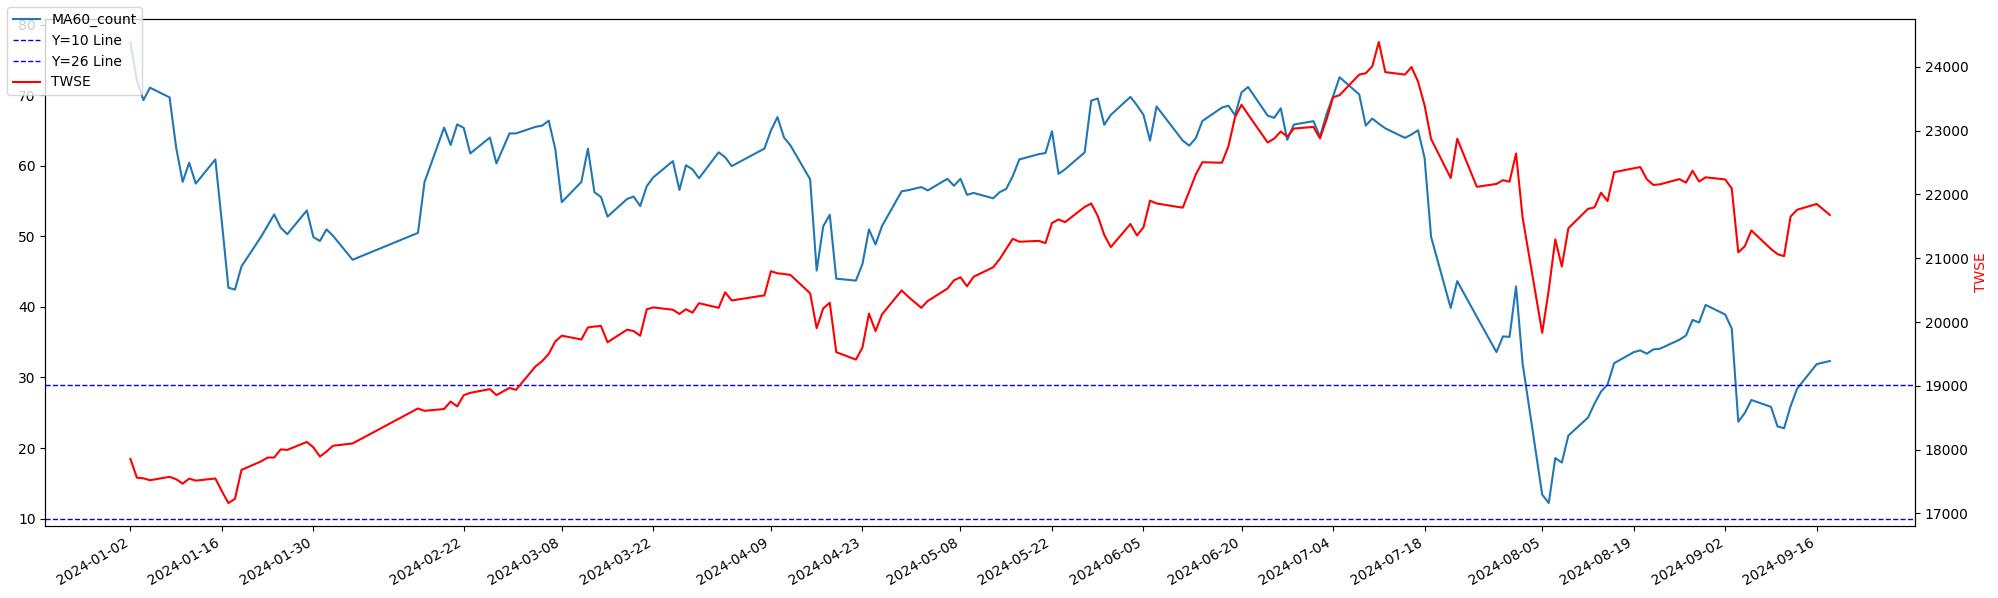

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

#只看最近
today = datetime.now().date()
one_month_ago = today - timedelta(days=200)

# 格式化日期 (Default)
# today_str = today.strftime('%Y-%m-%d')
# one_month_ago = one_month_ago.strftime('%Y-%m-%d')

today_str = '2024-12-31'
one_month_ago = '2024-01-01'


#疊圖加權指數
twse_index = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_index['Date'] = pd.to_datetime(twse_index['Date'])
twse_index_adj = twse_index[ (twse_index['Date'] >= one_month_ago) &  (twse_index['Date'] <= today_str) ]

MA_count_list_adj = MA_count_list[(MA_count_list['date'] >= one_month_ago) & (MA_count_list['date'] <= today_str)]
MA_count_list_adj['date'] = pd.to_datetime(MA_count_list_adj['date'])

# 設置圖表
fig, ax1 = plt.subplots(figsize=(20, 6))

# 繪製每條MA線
for column in MA_count_list_adj.columns[3:]:
    ax1.plot(MA_count_list_adj['date'], MA_count_list_adj[column], label=column)

ax1.axhline(y=10, color='blue', linestyle='--', linewidth=1, label='Y=10 Line')
ax1.axhline(y=29, color='blue', linestyle='--', linewidth=1, label='Y=26 Line')
# 標題和標籤
# ax1.title('Moving Average Counts Over Time')
# ax1.xlabel('Date')
# ax1.ylabel('Count(%)')
# ax1.legend()
# ax1.grid(True)


# 設置x軸刻度為實際存在的日期
ax1.set_xticks(MA_count_list_adj['date'])

# 格式化 x 轴为日期格式
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# 自动旋转日期标签以避免重叠
fig.autofmt_xdate()

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制 merged_hist 的折线图
ax2.plot(twse_index_adj['Date'], twse_index_adj['價格指數值'], color='red', linestyle='-', label='TWSE')
ax2.set_xticks(twse_index_adj['Date'])

# 设置第二个 y 轴的标签
ax2.set_ylabel('TWSE', color='red')

ax1.set_xticks(ax1.get_xticks()[::10])  # 每隔5个标签显示一个

#fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0))
fig.legend(loc='upper left')
# 自动调整布局以适应标签
fig.tight_layout()

# 显示图表
plt.show()
